In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from azure.storage.blob import BlobServiceClient, generate_blob_sas, BlobSasPermissions
from datetime import datetime, timedelta
import urllib.request
from PIL import Image
import numpy as np
import time

2023-10-22 04:26:48.054310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 04:26:48.829269: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-22 04:26:48.829340: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-10-22 04:26:48.829347: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [3]:
account = "test"   # Azure account name
key = "test"      # Azure Storage account access key  
connect_str = "test"
container = "images"
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

In [4]:
def generate_SAS():
    blob_list = []
    container_client_analysis = blob_service_client.get_container_client(container=container)

    
    blob_list = []
    for blob_i in container_client_analysis.list_blobs():
        blob_list.append(blob_i.name)
        
    sas_url_lst = []
    
    for j in range(len(blob_list)):
        sas_analysis = generate_blob_sas(account_name = account,
                        container_name = container,
                        blob_name = blob_list[j],
                        account_key=key,
                        permission=BlobSasPermissions(read=True),
                        expiry=datetime.utcnow() + timedelta(hours=1))
        sas_url = 'https://' + account+'.blob.core.windows.net/' + container + '/' + blob_list[j] + '?' + sas_analysis
        sas_url_lst.append(sas_url)
    return sas_url_lst   

In [5]:
x= generate_SAS()

In [6]:
def load_dataset():
    lst_img = []
    # Open the image file
    #y = x[:100]
    for i in x:
        image_data = urllib.request.urlopen(i)
        image = Image.open(image_data)
        image = image.resize((50,50))
        image_array = np.array(image)
        lst_img.append(image_array)
        #print(image_array.shape)

    arr_img = np.array(lst_img)
    #arr_img = np.array(lst_img)
    split_ratio = 0.8
    np.random.shuffle(arr_img)
    size = int(arr_img.shape[0]*split_ratio) 
    training, test = arr_img[:size,:], arr_img[size:,:]
    return training,test

In [7]:
x_train,x_test = load_dataset()

In [8]:
x_test.shape

(2500, 50, 50)

In [9]:
test_image = x_train[0]


In [10]:
test_image

array([[ 35,  38,  37, ...,  63,  65,  49],
       [ 40,  40,  41, ...,  64,  68,  53],
       [ 49,  46,  48, ...,  65,  70,  57],
       ...,
       [ 98, 108, 110, ..., 108, 115, 116],
       [101, 109, 108, ...,  97,  86, 117],
       [110, 104, 107, ...,  74,  72,  99]], dtype=uint8)

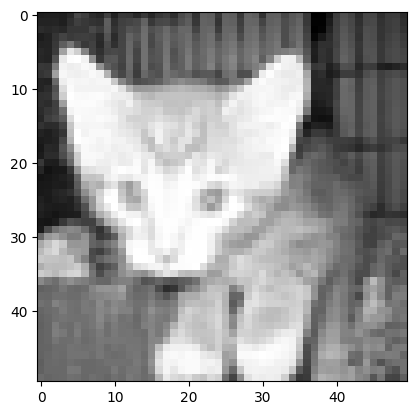

In [11]:
plt.imshow(test_image,cmap="gray")
plt.show()

In [12]:
x_train = x_train.astype("float32") / 255.0
x_train = tf.expand_dims(x_train, -1)
x_test = x_test.astype("float32") / 255.0
x_test = tf.expand_dims(x_test, -1)

In [13]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [88]:
latent_dim = 128

encoder_inputs = keras.Input(shape=(50 , 50, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
#x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
#x = layers.Conv2D(512, 3, activation="relu", strides=2, padding="same")(x)
#x = layers.Conv2D(1024, 32, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
#x = layers.Dense(512, activation="relu")(x)
#x = layers.Dense(1024, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 conv2d_27 (Conv2D)             (None, 25, 25, 32)   320         ['input_19[0][0]']               
                                                                                                  
 batch_normalization_54 (BatchN  (None, 25, 25, 32)  128         ['conv2d_27[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_28 (Conv2D)             (None, 13, 13, 64)   18496       ['batch_normalization_54[0]

In [89]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(25* 25 *128 , activation="relu")(latent_inputs)
x = layers.Reshape((25, 25, 128))(x)
#x = layers.Conv2DTranspose(512, 1, activation="relu", strides=1, padding="same")(x)
#x = layers.Conv2DTranspose(512, 1, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2DTranspose(256, 1, activation="relu", strides=1, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=1, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=1, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 128)]             0         
                                                                 
 dense_29 (Dense)            (None, 80000)             10320000  
                                                                 
 reshape_9 (Reshape)         (None, 25, 25, 128)       0         
                                                                 
 conv2d_transpose_45 (Conv2D  (None, 25, 25, 256)      33024     
 Transpose)                                                      
                                                                 
 batch_normalization_57 (Bat  (None, 25, 25, 256)      1024      
 chNormalization)                                                
                                                                 
 conv2d_transpose_46 (Conv2D  (None, 50, 50, 128)      2950

In [90]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



In [91]:
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam', loss='binary_crossentropy')
#vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, loss='binary_crossentropy'))
vae.fit(x_train, epochs=100, batch_size=128)

Epoch 1/100
79/79 [==============================] - 16s 139ms/step - loss: 1685.8996 - reconstruction_loss: 1632.3947 - kl_loss: 10.6756
Epoch 2/100
79/79 [==============================] - 11s 138ms/step - loss: 1574.4240 - reconstruction_loss: 1547.5510 - kl_loss: 20.5660
Epoch 3/100
79/79 [==============================] - 11s 139ms/step - loss: 1552.2069 - reconstruction_loss: 1524.9297 - kl_loss: 25.0799
Epoch 4/100
79/79 [==============================] - 11s 140ms/step - loss: 1540.4894 - reconstruction_loss: 1510.9615 - kl_loss: 27.4057

In [97]:
print("The dimension of the x_test are: ",x_test.shape)

The dimension of the x_test are:  (2500, 50, 50, 1)


In [98]:
encoded_data = encoder.predict(x_test)

79/79 [==============================] - 0s 1ms/step


In [99]:
im1 = decoder.predict(encoded_data[0])

79/79 [==============================] - 1s 12ms/step


In [100]:
im1.shape

(2500, 50, 50, 1)

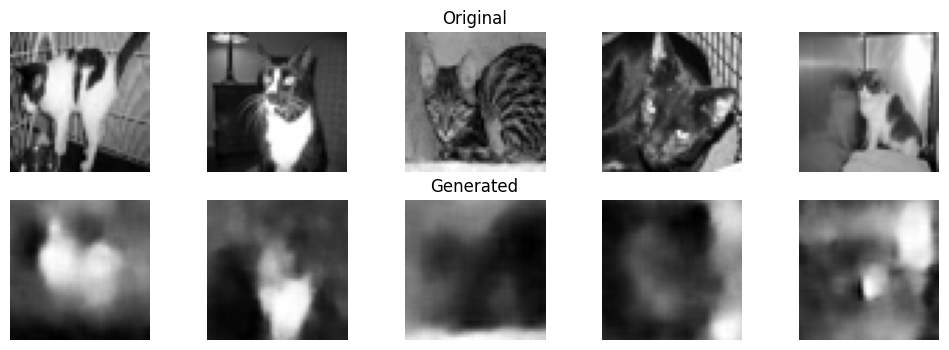

In [101]:
# Create 5 sample images
num_images = 5
image_shape = (50, 50, 1)

# Create a figure with two grids (top and bottom)
fig, axs = plt.subplots(2, num_images, figsize=(12, 4))

# Titles for the grids
titles = ["Original", "Generated"]

# Generate and display the images in the grids
for i in range(num_images):
    original_image = x_test[i]  # Replace with your actual image data
    generated_image = im1[i]  # Replace with your actual generated image data

    # Display original image in the top grid
    axs[0, i].imshow(original_image, cmap='gray')
    #axs[0, i].set_title(titles[0])
    axs[0, i].axis('off')

    # Display generated image in the bottom grid
    axs[1, i].imshow(generated_image, cmap='gray')
    #axs[1, i].set_title(titles[1])
    axs[1, i].axis('off')

# Add titles to the rows
for i in range(2):
    axs[i, 2].set_title(titles[i], loc='center')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Show the plot
plt.show()
